# RICE LEAF DISEASE DETECTION USING CONVOLUTIONAL NEURAL NETWORK


**IMPORT LIBRARY CNN**

In [1]:
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sn

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras.models import load_model

**INITIAL STATE**

In [2]:
EPOCHS = 100
INIT_LR = 1e-1
BS = 32
default_image_size = tuple((64, 64))
image_size = 0
directory_root = "../input/riceleaf"
width=64
height=64
depth=3
n_folds= 5

**LOADING DATASET**

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Health ...
[INFO] Processing Brown spot ...
[INFO] Processing Bacterial leaf blight ...
[INFO] Processing Leaf smut ...
[INFO] Image loading completed


In [5]:
image_size = len(image_list)

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [7]:
print(label_binarizer.classes_)

['Bacterial leaf blight' 'Brown spot' 'Health' 'Leaf smut']


In [8]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

**SPLITTING DATASET**

In [9]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


**CREATING MODEL CNN**

In [10]:
def create_model():
    
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
    
#Layer 1
    model.add(Conv2D(16, (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

#Layer 2
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

#Layer 3
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

#Layer 4
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

#Layer 5
#model.add(Conv2D(256, (3, 3), padding="same"))
#model.add(Activation("relu"))
#model.add(BatchNormalization(axis=chanDim))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#Classification Layer
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation("softmax"))

    return model

2022-08-07 04:54:15.825374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 04:54:15.927120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 04:54:15.927910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 04:54:15.929133: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

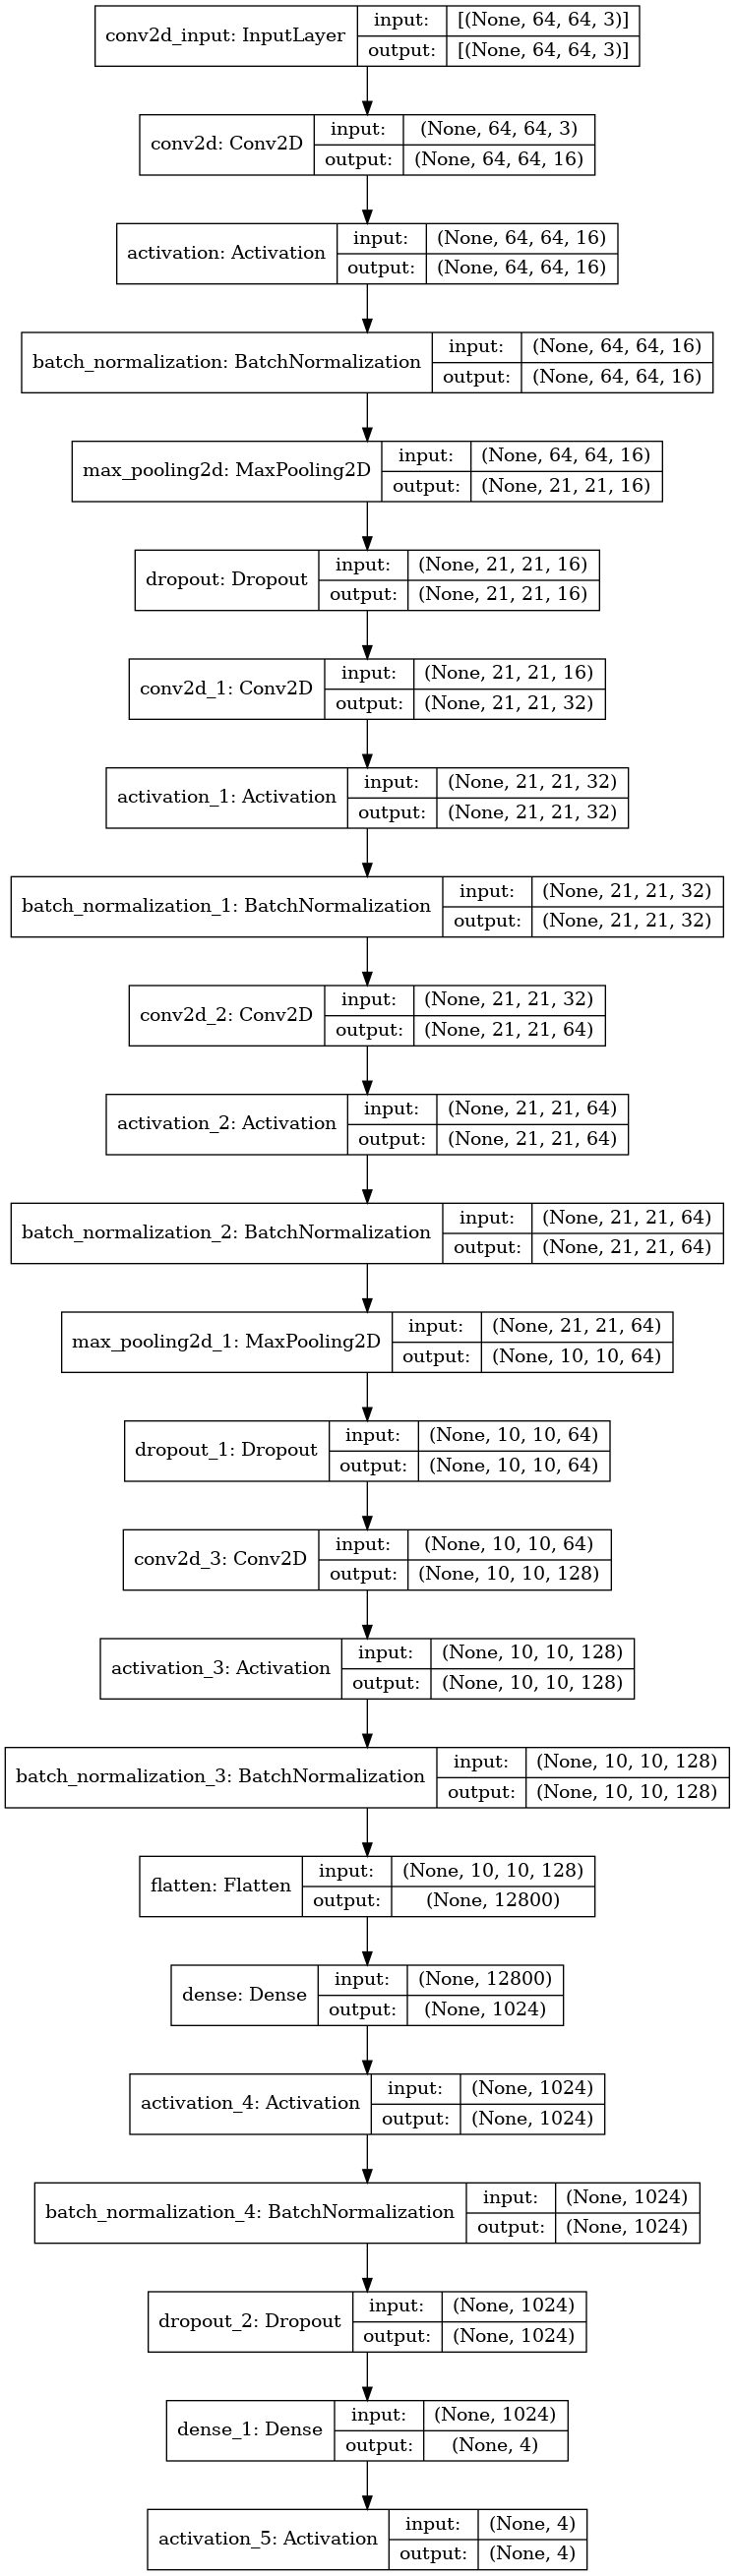

In [11]:
model = create_model()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 21, 21, 32)        0

**INITIATE OPTIMIZER**

In [13]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


**CHECKPOINT CREATING MODEL FOR CROSS VALIDATION**

In [14]:
filepath="model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size):
    model = create_model()
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    results = model.fit(t_x, t_y,validation_data=(val_x, val_y), epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)  
    print("Val Score: ", model.evaluate(val_x, val_y))
    
    return results

**TRAINING DATA WITH CROSS VALIDATION**

In [15]:
#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs=EPOCHS, batch_size=BS))
print("======="*12, end="\n\n\n")

Training on Fold:  1


2022-08-07 04:54:21.673786: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-08-07 04:54:23.408413: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


320/320 [==============================] - 11s 9ms/step - loss: 4.0802 - accuracy: 0.6809 - val_loss: 3.6970 - val_accuracy: 0.6016

Epoch 00001: val_loss improved from inf to 3.69699, saving model to model.h5
Epoch 2/100
320/320 [==============================] - 2s 7ms/step - loss: 0.7052 - accuracy: 0.8084 - val_loss: 0.9056 - val_accuracy: 0.7309

Epoch 00002: val_loss improved from 3.69699 to 0.90556, saving model to model.h5
Epoch 3/100
320/320 [==============================] - 2s 8ms/step - loss: 0.3413 - accuracy: 0.8785 - val_loss: 0.5702 - val_accuracy: 0.8215

Epoch 00003: val_loss improved from 0.90556 to 0.57018, saving model to model.h5
Epoch 4/100
320/320 [==============================] - 3s 9ms/step - loss: 0.5173 - accuracy: 0.8490 - val_loss: 0.1990 - val_accuracy: 0.9277

Epoch 00004: val_loss improved from 0.57018 to 0.19904, saving model to model.h5
Epoch 5/100
320/320 [==============================] - 2s 8ms/step - loss: 0.3169 - accuracy: 0.8960 - val_loss: 0.

**RESULT OF TRAINING DATA PROCESS**

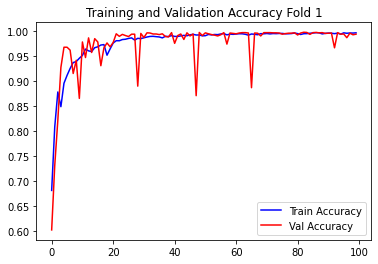

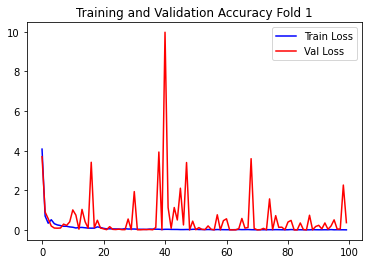

In [16]:
#FOLD 1
#Train and validation accuracy
plt.title('Training and Validation Accuracy Fold 1')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy', color='blue', )
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy', color='red', )
plt.legend()
plt.savefig("Accuracy_fold 1.jpg")
plt.show()

plt.figure()

#Train and validation loss
plt.title('Training and Validation Accuracy Fold 1')
plt.plot(model_history[0].history['loss'], label='Train Loss', color='blue', )
plt.plot(model_history[0].history['val_loss'], label='Val Loss', color='red', )
plt.legend()
plt.savefig("Loss_fold 1.jpg")
plt.show()

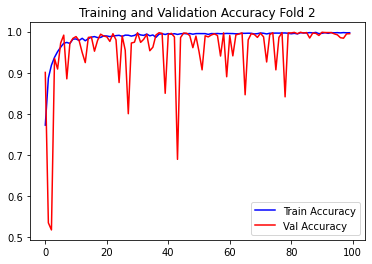

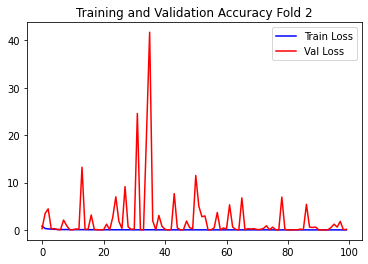

In [17]:
#FOLD 2
#Train and validation accuracy
plt.title('Training and Validation Accuracy Fold 2')
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy', color='blue', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy', color='red', )
plt.legend()
plt.savefig("Accuracy_fold 2.jpg")
plt.show()

plt.figure()

#Train and validation loss
plt.title('Training and Validation Accuracy Fold 2')
plt.plot(model_history[1].history['loss'], label='Train Loss', color='blue', )
plt.plot(model_history[1].history['val_loss'], label='Val Loss', color='red', )
plt.legend()
plt.savefig("Loss_fold 2.jpg")
plt.show()

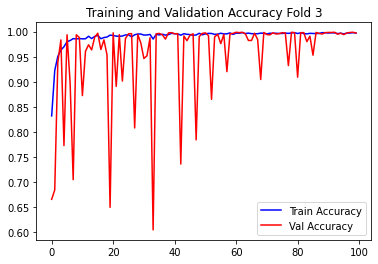

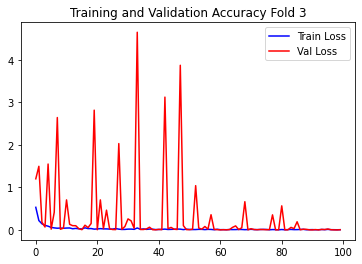

In [18]:
#FOLD 3
#Train and validation accuracy
plt.title('Training and Validation Accuracy Fold 3')
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy', color='blue', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy', color='red', )
plt.legend()
plt.savefig("Accuracy_fold 3.jpg")
plt.show()

plt.figure()

#Train and validation loss
plt.title('Training and Validation Accuracy Fold 3')
plt.plot(model_history[2].history['loss'], label='Train Loss', color='blue', )
plt.plot(model_history[2].history['val_loss'], label='Val Loss', color='red', )
plt.legend()
plt.savefig("Loss_fold 3.jpg")
plt.show()

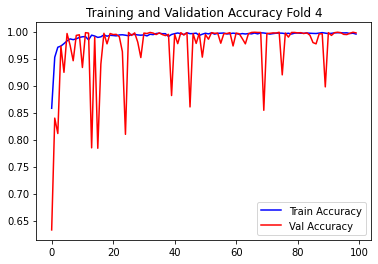

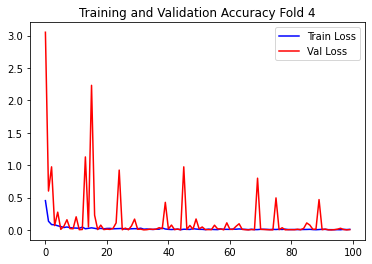

In [19]:
#FOLD 4
#Train and validation accuracy
plt.title('Training and Validation Accuracy Fold 4')
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy', color='blue', )
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy', color='red', )
plt.legend()
plt.savefig("Accuracy_fold 4.jpg")
plt.show()

plt.figure()

#Train and validation loss
plt.title('Training and Validation Accuracy Fold 4')
plt.plot(model_history[3].history['loss'], label='Train Loss', color='blue', )
plt.plot(model_history[3].history['val_loss'], label='Val Loss', color='red', )
plt.legend()
plt.savefig("Loss_fold 4.jpg")
plt.show()

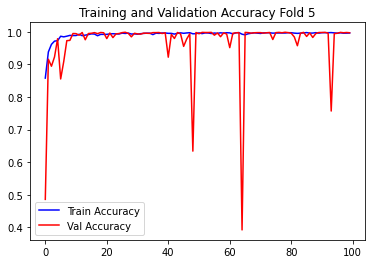

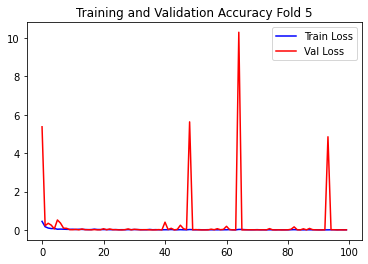

In [20]:
#FOLD 5
#Train and validation accuracy
plt.title('Training and Validation Accuracy Fold 5')
plt.plot(model_history[4].history['accuracy'], label='Train Accuracy', color='blue', )
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy', color='red', )
plt.legend()
plt.savefig("Accuracy_fold 5.jpg")
plt.show()

plt.figure()

#Train and validation loss
plt.title('Training and Validation Accuracy Fold 5')
plt.plot(model_history[4].history['loss'], label='Train Loss', color='blue', )
plt.plot(model_history[4].history['val_loss'], label='Val Loss', color='red', )
plt.legend()
plt.savefig("Loss_fold 5.jpg")
plt.show()

**LOAD BEST MODEL BY RESULT**

In [21]:
modeltest = load_model('model.h5')

**EVALUATING PARAMETER**

In [22]:
print("[INFO] evaluating network...")
predictions = modeltest.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
	predictions.argmax(axis=1), target_names=label_binarizer.classes_))

[INFO] evaluating network...
                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      1.00      1.00       859
           Brown spot       0.99      1.00      0.99       837
               Health       1.00      1.00      1.00       767
            Leaf smut       1.00      0.99      0.99       737

             accuracy                           1.00      3200
            macro avg       1.00      1.00      1.00      3200
         weighted avg       1.00      1.00      1.00      3200



In [23]:
print("[INFO] Calculating model accuracy")
scores = modeltest.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
100/100 [==============================] - 0s 3ms/step - loss: 0.0048 - accuracy: 0.9966
Test Accuracy: 99.65624809265137


**CONFUSION MATRIX**

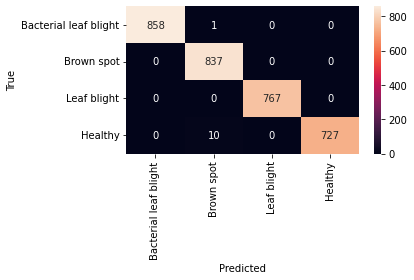

In [24]:
confusion_matrix = metrics.confusion_matrix(y_test.argmax(axis=1),predictions.argmax(axis=1))
x_axis_labels = ['Bacterial leaf blight', 'Brown spot', 'Leaf blight', 'Healthy']
y_axis_labels = ['Bacterial leaf blight', 'Brown spot', 'Leaf blight', 'Healthy']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()